# Import Libraries and Load New Dataset

In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.model_selection import train_test_split


# Load data
train = pd.read_csv('../data/new_train.csv')
print("Shape of train:", train.shape)
train.head()
print(list(train.columns))

Shape of train: (1460, 203)
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'Alley', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'LandContour_HLS', 'LandCon

# Select Features

In [2]:
# Load data
train = pd.read_csv('../data/new_train.csv')

# Drop 'Id' if present
if 'Id' in train.columns:
    train.drop(columns=['Id'], inplace=True)

# Separate target and features
y = train['SalePrice']
X = train.drop(columns=['SalePrice'])

# Pearson Correlation for Numerical Features
correlation_threshold = 0.2
correlation_matrix = X.corrwith(y)
num_high_corr_features = correlation_matrix[abs(correlation_matrix) > correlation_threshold].index.tolist()

# Keep only highly correlated features
selected_features = list(set(num_high_corr_features))

# Update X to include only selected features
X = X[selected_features]

# Split into Train (80%) and Dev (20%)
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)

# Train initial XGBoost model
initial_xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
initial_xgb_model.fit(X_train, y_train)

# Get Feature Importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': initial_xgb_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Keep the top 40 features
top_features = feature_importances.head(40)['Feature'].tolist()

# Recursive Feature Elimination (RFE) to Further Reduce Features
rfe_selector = RFE(estimator=initial_xgb_model, n_features_to_select=30, step=1)
rfe_selector.fit(X_train[top_features], y_train)

rfe_selected_features = [feature for feature, selected in zip(top_features, rfe_selector.support_) if selected]

# Filter X_train and X_dev to only RFE-selected features
X_train_rfe = X_train[rfe_selected_features]
X_dev_rfe = X_dev[rfe_selected_features]

# Re-train XGBoost model with RFE-selected features
final_xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
final_xgb_model.fit(X_train_rfe, y_train)

# Print Feature Mismatch Before SHAP
print("\n--- Feature Debugging Before SHAP ---")
print("Train Features (X_train):", list(X_train_rfe.columns))
print("Dev Features (X_dev):", list(X_dev_rfe.columns))
print("RFE Selected Features:", rfe_selected_features)


# Convert all boolean columns to integers
X_dev_rfe = X_dev_rfe.astype({col: int for col in X_dev_rfe.select_dtypes(include='bool').columns})

# SHAP Analysis - Ensure exact feature alignment
explainer = shap.Explainer(lambda x: final_xgb_model.predict(pd.DataFrame(x, columns=X_dev_rfe.columns)), X_dev_rfe, algorithm="permutation")
shap_values = explainer(X_dev_rfe)

# Calculate SHAP importance
shap_importance = pd.DataFrame({'Feature': rfe_selected_features, 'SHAP_Importance': np.abs(shap_values.values).mean(axis=0)})
shap_importance = shap_importance.sort_values(by='SHAP_Importance', ascending=False)

# Keep the top 25 most influential features based on SHAP
final_selected_features = shap_importance.head(25)['Feature'].tolist()

# Evaluate Final Model
y_pred_final = final_xgb_model.predict(X_dev_rfe)
final_rmse = root_mean_squared_error(y_dev, y_pred_final)

print(f"\nFinal RMSE: {final_rmse}")
print("Final Selected Features:", final_selected_features)



--- Feature Debugging Before SHAP ---
Train Features (X_train): ['Qual_LivArea_Interaction', 'OverallQual', 'BsmtQual', 'GarageCars', 'TotalSF', 'TotalBsmtSF', 'HouseAge', 'GarageFinish', 'YearBuilt', 'MSZoning_RM', 'KitchenQual', 'BsmtFinSF1', '2ndFlrSF', 'CentralAir', 'MSZoning_RL', 'TotalBath', 'OpenPorchSF', 'lot_frontage_lot_area', '1stFlrSF', 'RemodAge', 'GarageQual', 'ExterQual', 'BsmtFinType1', 'YearRemodAdd', 'SaleType_New', 'LotArea', 'FireplaceQu', 'BsmtCond', 'BsmtExposure', 'GarageCond']
Dev Features (X_dev): ['Qual_LivArea_Interaction', 'OverallQual', 'BsmtQual', 'GarageCars', 'TotalSF', 'TotalBsmtSF', 'HouseAge', 'GarageFinish', 'YearBuilt', 'MSZoning_RM', 'KitchenQual', 'BsmtFinSF1', '2ndFlrSF', 'CentralAir', 'MSZoning_RL', 'TotalBath', 'OpenPorchSF', 'lot_frontage_lot_area', '1stFlrSF', 'RemodAge', 'GarageQual', 'ExterQual', 'BsmtFinType1', 'YearRemodAdd', 'SaleType_New', 'LotArea', 'FireplaceQu', 'BsmtCond', 'BsmtExposure', 'GarageCond']
RFE Selected Features: ['Qual

PermutationExplainer explainer:  38%|█████████████████████████████████████████████████▎                                                                                 | 110/292 [00:00<?, ?it/s]

PermutationExplainer explainer:  39%|████████████████████████████████████████████████                                                                           | 114/292 [00:10<00:04, 36.26it/s]

PermutationExplainer explainer:  40%|█████████████████████████████████████████████████▋                                                                         | 118/292 [00:10<00:05, 33.19it/s]

PermutationExplainer explainer:  42%|███████████████████████████████████████████████████▍                                                                       | 122/292 [00:10<00:04, 34.43it/s]

PermutationExplainer explainer:  43%|█████████████████████████████████████████████████████                                                                      | 126/292 [00:10<00:05, 32.45it/s]

PermutationExplainer explainer:  45%|██████████████████████████████████████████████████████▊                                                                    | 130/292 [00:10<00:05, 32.39it/s]

PermutationExplainer explainer:  46%|████████████████████████████████████████████████████████▍                                                                  | 134/292 [00:10<00:04, 32.00it/s]

PermutationExplainer explainer:  47%|██████████████████████████████████████████████████████████▏                                                                | 138/292 [00:10<00:04, 31.51it/s]

PermutationExplainer explainer:  49%|███████████████████████████████████████████████████████████▊                                                               | 142/292 [00:11<00:04, 30.93it/s]

PermutationExplainer explainer:  50%|█████████████████████████████████████████████████████████████▌                                                             | 146/292 [00:11<00:04, 31.92it/s]

PermutationExplainer explainer:  51%|███████████████████████████████████████████████████████████████▏                                                           | 150/292 [00:11<00:04, 31.49it/s]

PermutationExplainer explainer:  53%|████████████████████████████████████████████████████████████████▊                                                          | 154/292 [00:11<00:04, 32.02it/s]

PermutationExplainer explainer:  54%|██████████████████████████████████████████████████████████████████▌                                                        | 158/292 [00:11<00:04, 31.65it/s]

PermutationExplainer explainer:  55%|████████████████████████████████████████████████████████████████████▏                                                      | 162/292 [00:11<00:04, 31.38it/s]

PermutationExplainer explainer:  57%|█████████████████████████████████████████████████████████████████████▉                                                     | 166/292 [00:11<00:04, 29.63it/s]

PermutationExplainer explainer:  58%|███████████████████████████████████████████████████████████████████████▏                                                   | 169/292 [00:11<00:04, 29.59it/s]

PermutationExplainer explainer:  59%|████████████████████████████████████████████████████████████████████████▍                                                  | 172/292 [00:12<00:04, 29.30it/s]

PermutationExplainer explainer:  60%|██████████████████████████████████████████████████████████████████████████▏                                                | 176/292 [00:12<00:03, 30.57it/s]

PermutationExplainer explainer:  62%|███████████████████████████████████████████████████████████████████████████▊                                               | 180/292 [00:12<00:03, 30.20it/s]

PermutationExplainer explainer:  63%|█████████████████████████████████████████████████████████████████████████████▌                                             | 184/292 [00:12<00:03, 30.74it/s]

PermutationExplainer explainer:  64%|███████████████████████████████████████████████████████████████████████████████▏                                           | 188/292 [00:12<00:03, 31.96it/s]

PermutationExplainer explainer:  66%|████████████████████████████████████████████████████████████████████████████████▉                                          | 192/292 [00:12<00:03, 31.15it/s]

PermutationExplainer explainer:  67%|██████████████████████████████████████████████████████████████████████████████████▌                                        | 196/292 [00:12<00:03, 30.90it/s]

PermutationExplainer explainer:  68%|████████████████████████████████████████████████████████████████████████████████████▏                                      | 200/292 [00:12<00:02, 31.26it/s]

PermutationExplainer explainer:  70%|█████████████████████████████████████████████████████████████████████████████████████▉                                     | 204/292 [00:13<00:03, 29.14it/s]

PermutationExplainer explainer:  71%|███████████████████████████████████████████████████████████████████████████████████████▏                                   | 207/292 [00:13<00:03, 27.51it/s]

PermutationExplainer explainer:  72%|████████████████████████████████████████████████████████████████████████████████████████▍                                  | 210/292 [00:13<00:02, 27.58it/s]

PermutationExplainer explainer:  73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                | 214/292 [00:13<00:02, 28.45it/s]

PermutationExplainer explainer:  75%|███████████████████████████████████████████████████████████████████████████████████████████▊                               | 218/292 [00:13<00:02, 29.48it/s]

PermutationExplainer explainer:  76%|█████████████████████████████████████████████████████████████████████████████████████████████▌                             | 222/292 [00:13<00:02, 31.51it/s]

PermutationExplainer explainer:  77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                           | 226/292 [00:13<00:02, 29.82it/s]

PermutationExplainer explainer:  79%|████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 230/292 [00:13<00:02, 30.99it/s]

PermutationExplainer explainer:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 234/292 [00:14<00:01, 30.05it/s]

PermutationExplainer explainer:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 238/292 [00:14<00:01, 31.03it/s]

PermutationExplainer explainer:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 242/292 [00:14<00:01, 31.68it/s]

PermutationExplainer explainer:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 246/292 [00:14<00:01, 31.09it/s]

PermutationExplainer explainer:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 250/292 [00:14<00:01, 31.97it/s]

PermutationExplainer explainer:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 254/292 [00:14<00:01, 31.11it/s]

PermutationExplainer explainer:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 258/292 [00:14<00:01, 31.47it/s]

PermutationExplainer explainer:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 262/292 [00:14<00:00, 31.66it/s]

PermutationExplainer explainer:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 266/292 [00:15<00:00, 32.56it/s]

PermutationExplainer explainer:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 270/292 [00:15<00:00, 31.75it/s]

PermutationExplainer explainer:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 274/292 [00:15<00:00, 31.37it/s]

PermutationExplainer explainer:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 278/292 [00:15<00:00, 31.49it/s]

PermutationExplainer explainer:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 282/292 [00:15<00:00, 31.76it/s]

PermutationExplainer explainer:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 286/292 [00:15<00:00, 31.46it/s]

PermutationExplainer explainer:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 290/292 [00:15<00:00, 30.26it/s]

PermutationExplainer explainer: 293it [00:15, 11.47it/s]                                                                                                                                          


Final RMSE: 28248.984375
Final Selected Features: ['Qual_LivArea_Interaction', 'TotalSF', 'BsmtFinSF1', 'OverallQual', 'TotalBsmtSF', 'FireplaceQu', 'HouseAge', 'GarageCars', 'TotalBath', 'KitchenQual', 'RemodAge', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtQual', 'GarageFinish', 'BsmtFinType1', 'lot_frontage_lot_area', 'BsmtExposure', 'ExterQual', '1stFlrSF', 'MSZoning_RM', '2ndFlrSF', 'OpenPorchSF', 'BsmtCond']


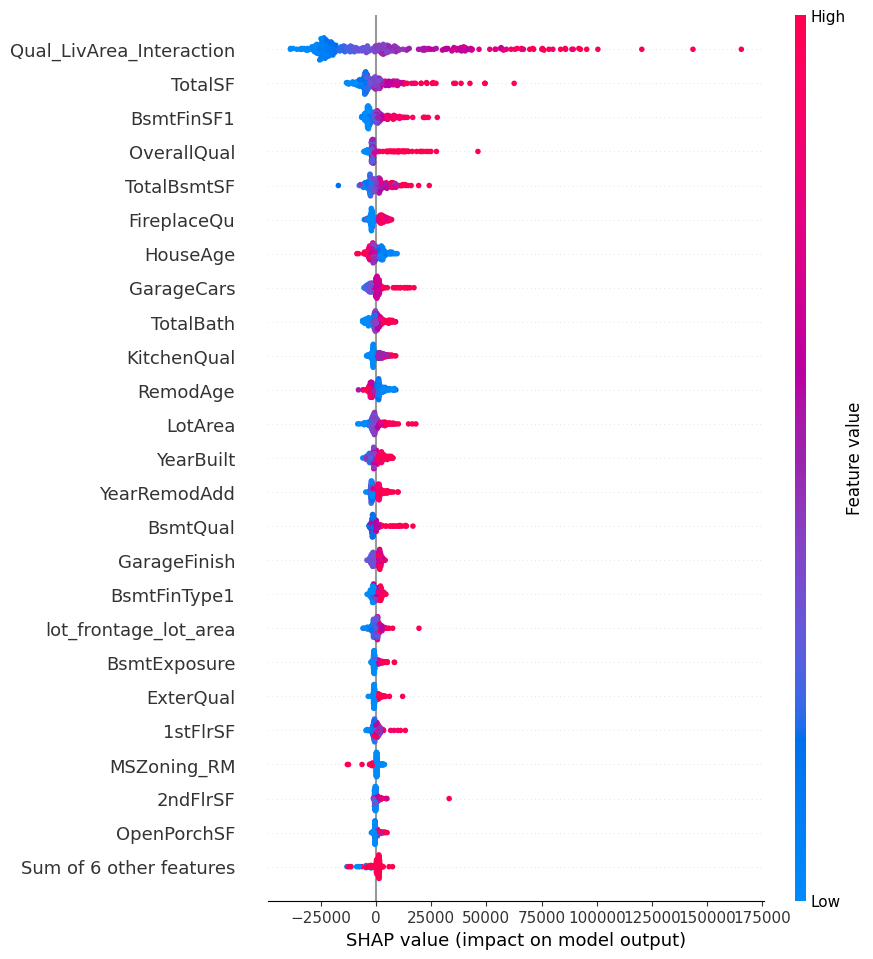

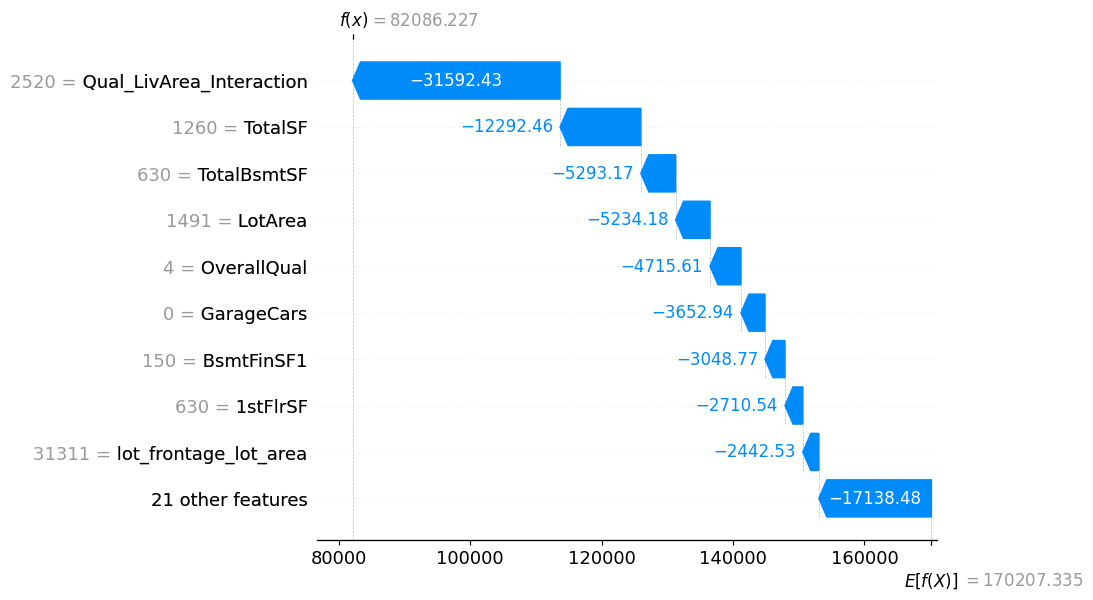

In [3]:
# SHAP Summary Plot (Beeswarm)
shap.plots.beeswarm(shap_values, max_display=25)
plt.tight_layout()


# SHAP Waterfall Plot for a Single Example
sample_index = 5  # any row index
shap.plots.waterfall(shap_values[sample_index])

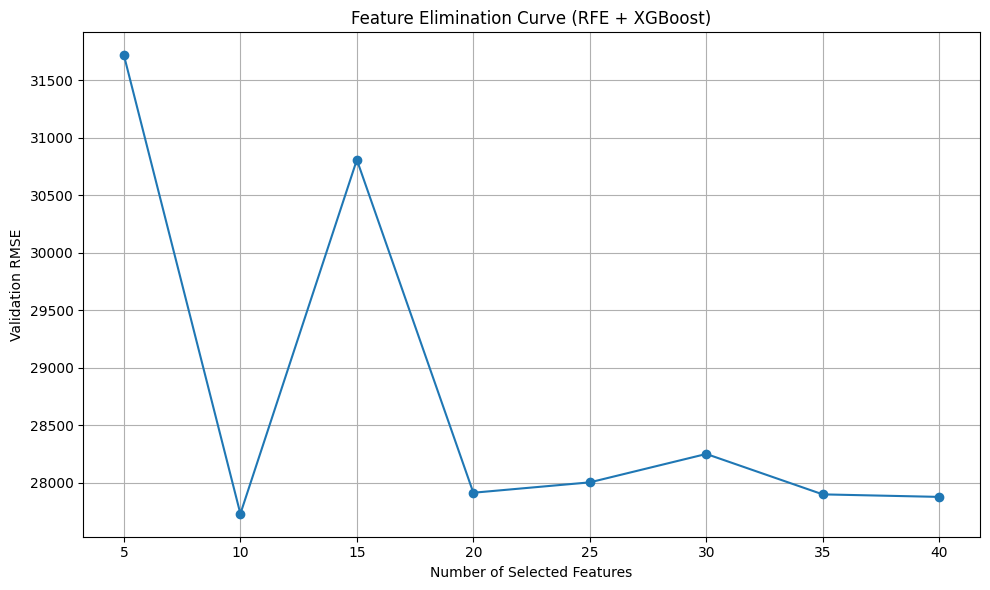

In [4]:
# Plot: Feature Elimination Curve (RMSE vs. Number of Features)
rmse_list = []
num_features_list = list(range(5, len(top_features)+1, 5))

for n in num_features_list:
    selector = RFE(estimator=initial_xgb_model, n_features_to_select=n, step=1)
    selector.fit(X_train[top_features], y_train)
    selected = X_train[top_features].columns[selector.support_]
    
    temp_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
    temp_model.fit(X_train[selected], y_train)
    
    y_pred = temp_model.predict(X_dev[selected])
    rmse = mean_squared_error(y_dev, y_pred) ** 0.5
    rmse_list.append(rmse)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, rmse_list, marker='o')
plt.title("Feature Elimination Curve (RFE + XGBoost)")
plt.xlabel("Number of Selected Features")
plt.ylabel("Validation RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

# Try New Features

In [5]:
selected_features = ['Qual_LivArea_Interaction', 'TotalSF', 'TotalBsmtSF', 'BsmtFinSF1', 'RemodAge', 'OverallQual', 'KitchenQual', 'BsmtQual', 'YearBuilt', 'GarageCars', 'BsmtExposure', 'GarageFinish', 'OpenPorchSF', 'ExterQual', 'FireplaceQu', 'GarageAge', 'TotalBath', '2ndFlrSF', 'BsmtFinType1', 'Fireplaces', 'Functional', 'MSZoning_RL', 'BsmtFullBath', '1stFlrSF', 'HouseAge', 'Neighborhood_Crawfor', 'CentralAir', 'KitchenAbvGr', 'Neighborhood_OldTown', 'TotRmsAbvGrd']
target = "SalePrice"

all_cols_needed = selected_features + [target]
df = train[all_cols_needed].copy()

print("Columns in use:\n", df.columns.tolist())
df.head()


Columns in use:
 ['Qual_LivArea_Interaction', 'TotalSF', 'TotalBsmtSF', 'BsmtFinSF1', 'RemodAge', 'OverallQual', 'KitchenQual', 'BsmtQual', 'YearBuilt', 'GarageCars', 'BsmtExposure', 'GarageFinish', 'OpenPorchSF', 'ExterQual', 'FireplaceQu', 'GarageAge', 'TotalBath', '2ndFlrSF', 'BsmtFinType1', 'Fireplaces', 'Functional', 'MSZoning_RL', 'BsmtFullBath', '1stFlrSF', 'HouseAge', 'Neighborhood_Crawfor', 'CentralAir', 'KitchenAbvGr', 'Neighborhood_OldTown', 'TotRmsAbvGrd', 'SalePrice']


,Qual_LivArea_Interaction,TotalSF,TotalBsmtSF,BsmtFinSF1,RemodAge,OverallQual,KitchenQual,BsmtQual,YearBuilt,GarageCars,...,MSZoning_RL,BsmtFullBath,1stFlrSF,HouseAge,Neighborhood_Crawfor,CentralAir,KitchenAbvGr,Neighborhood_OldTown,TotRmsAbvGrd,SalePrice
0,11970,2566,856,706,5,7,3,4,2003,2,...,True,1,856,5,False,1,1,False,8,208500
1,7572,2524,1262,978,31,6,2,4,1976,2,...,True,0,1262,31,False,1,1,False,6,181500
2,12502,2706,920,486,6,7,3,4,2001,2,...,True,1,920,7,False,1,1,False,6,223500
3,12019,2473,756,216,36,7,3,3,1915,3,...,True,1,961,91,True,1,1,False,7,140000
4,17584,3343,1145,655,8,8,3,4,2000,3,...,True,1,1145,8,False,1,1,False,9,250000


# Define features and target

In [6]:
X = df[selected_features]
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1460, 30)
y shape: (1460,)


# Split Train and Dev Set

In [7]:
X_train, X_dev, y_train, y_dev = train_test_split(
    X, y, test_size=0.2, random_state=36
)
print("Train shapes:", X_train.shape, y_train.shape)
print("Dev shapes:", X_dev.shape, y_dev.shape)


Train shapes: (1168, 30) (1168,)
Dev shapes: (292, 30) (292,)


# Train XGBoost

In [8]:
model = XGBRegressor(
    n_estimators=180,
    learning_rate=0.02,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_alpha=10,
    reg_lambda=10,
    gamma=5,
    random_state=36,
    early_stopping_rounds=50
)

model.fit(
    X_train, y_train,
    eval_set=[(X_dev, y_dev)],
    verbose=10
)

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_dev_pred = model.predict(X_dev)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
dev_rmse = root_mean_squared_error(y_dev, y_dev_pred)

print(f"Train RMSE: {train_rmse:,.0f}")
print(f"Dev RMSE: {dev_rmse:,.0f}")

[0]	validation_0-rmse:82824.75716


[10]	validation_0-rmse:73564.48468


[20]	validation_0-rmse:65665.17073


[30]	validation_0-rmse:59045.70942


[40]	validation_0-rmse:53592.75701


[50]	validation_0-rmse:49100.11313


[60]	validation_0-rmse:45308.58193


[70]	validation_0-rmse:42120.87716


[80]	validation_0-rmse:39460.40994


[90]	validation_0-rmse:37459.55306


[100]	validation_0-rmse:35788.10865


[110]	validation_0-rmse:34368.51152


[120]	validation_0-rmse:33190.57501


[130]	validation_0-rmse:32258.37146


[140]	validation_0-rmse:31298.76419


[150]	validation_0-rmse:30647.78777


[160]	validation_0-rmse:30101.00742

[170]	validation_0-rmse:29594.35876


[179]	validation_0-rmse:29181.29680

Train RMSE: 26,099
Dev RMSE: 29,181


# Residual Analysis

In [9]:
# Compute residuals: actual - predicted
residuals = y_dev - y_dev_pred
df_res = pd.DataFrame({
    'Actual': y_dev,
    'Predicted': y_dev_pred,
    'Residual': residuals
})
df_res.head(10)


,Actual,Predicted,Residual
1057,248000,214318.703125,33681.296875
1391,124000,148126.187500,-24126.187500
291,135900,141652.500000,-5752.500000
226,290000,275847.125000,14152.875000
622,135000,129814.179688,5185.820312
514,96500,108747.171875,-12247.171875
1383,112000,135451.234375,-23451.234375
524,315750,283192.937500,32557.062500
145,130000,177817.640625,-47817.640625
209,145000,143506.687500,1493.312500


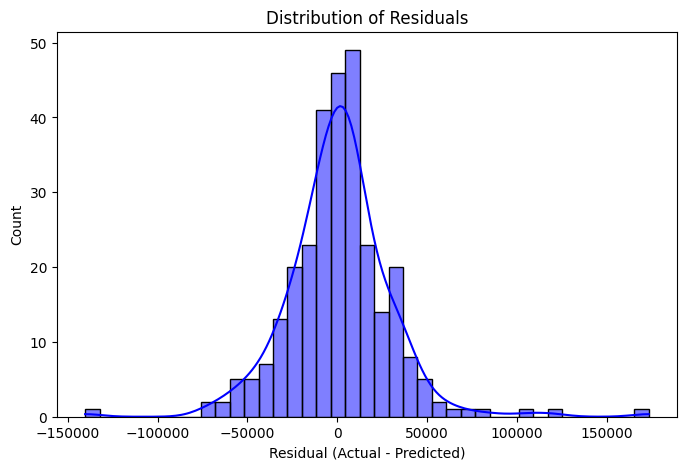

In [10]:
# Distribution of Residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.show()


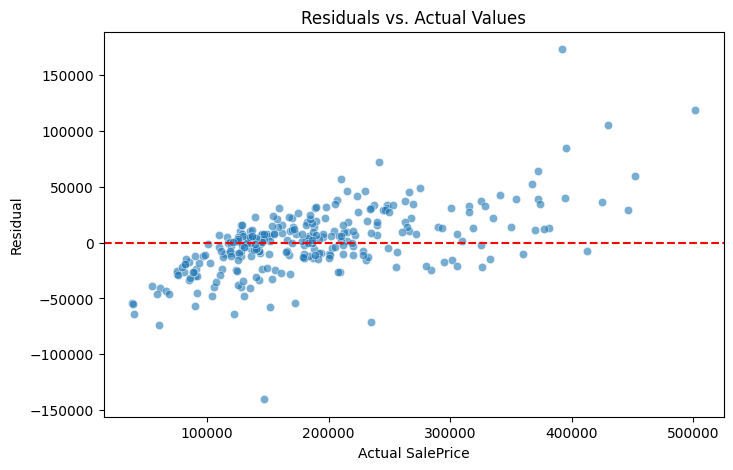

In [11]:
# Residuals vs. Actual
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_dev, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Actual Values')
plt.xlabel('Actual SalePrice')
plt.ylabel('Residual')
plt.show()


# Load and Predict on Test Dataset

In [12]:

test = pd.read_csv('../data/new_test.csv')
test_ids = test['Id']
test = test[list(X_train.columns)]
y_test_pred = model.predict(test)
submission = pd.DataFrame({'Id': test_ids, 'SalePrice': y_test_pred})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'.")

Submission file saved as 'submission.csv'.
